# Imports #

In [1432]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import math

# Functions #

In [1433]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.cvtColor(cv2.imread(os.path.join(folder,filename)), cv2.COLOR_BGR2GRAY)
        if img is not None:
            images.append(img)
    return images

In [1434]:
def plot(image):
    plt.imshow(image,cmap='gray', vmin=0, vmax=255)
    plt.axis('off')  # Turn off axis

In [1435]:
def plot_all(images):
    size = math.ceil(math.sqrt(len(images)))
    fig, axs = plt.subplots(size, size, figsize=(15, 10))
    for i in range(size):
        for j in range(size):
            if i * size + j < len(images):
                axs[i, j].imshow(images[i * size + j], cmap='gray')
                axs[i, j].axis('off')
            else:
                axs[i, j].axis('off')
    plt.show()

In [1436]:
def equalize_histogram(image):
    if any(np.unique(image) >= 127) and any(np.unique(image) < 127):
        return image
    return cv2.threshold(cv2.equalizeHist(image), 127, 255, cv2.THRESH_BINARY)[1]

In [1437]:
def detect_inversion(image):
    if image.mean() < 115:
        return cv2.bitwise_not(image)
    return image

In [1438]:
# Find tilting of the image and rotate it to be straight on a white background
def check_tilt(image):
    angle = find_angle(image)
    if abs(angle) < 5:
        # No tilting / slight tilting can be tolerated
        return image
    M = cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), angle, 1)
    image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]), borderValue=255)
    return np.uint8(image)

In [1439]:
# find the angle of rotation of the qr code, it may be slightly tilted
def find_angle(image):
    edges = cv2.Canny(np.uint8(image), 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 70)
    
    angles = []
    angle = 0
    if lines is not None and len(lines) > 130:
        for line in lines:
            for rho, theta in line:
                if np.pi / 4 < theta < 3 * np.pi / 4:
                    angles.append(np.rad2deg(theta - np.pi / 2))
                elif np.pi / 4 < -theta < 3 * np.pi / 4:
                    angles.append(np.rad2deg(theta + np.pi / 2))

    if len(angles) > 0:
        angle = np.median(angles) - 2
    return angle

In [1440]:
def remove_salt_and_pepper(image, factor):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)

    ms = np.log(np.abs(fshift) + 1)
    average = np.average(ms)

    if average > factor:
        return try_lowpass(image, 26, True)
    return image

In [1441]:
# Export processed image into a file in test_outputs folder
def export_image(image, path):
    cv2.imwrite(path, image)

In [1442]:
def fata7i_ya_warda(image, structuring_element_size, iterations=1, structuring_element=cv2.MORPH_RECT):
    se_rect = cv2.getStructuringElement(structuring_element, structuring_element_size)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, se_rect, iterations=iterations)

In [1443]:
def afeli_ya_warda(image, structuring_element_size, iterations=1):
    se_rect = cv2.getStructuringElement(cv2.MORPH_RECT, structuring_element_size)
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, se_rect, iterations=iterations)

In [1444]:
def threshold(image, factor):
    _, image = cv2.threshold(image, factor, 255, cv2.THRESH_BINARY)
    return image

In [1445]:
def sharpen(image, iterations=1):
    temp_image = image
    
    kernel = np.array([[0,-1,0],
                       [-1,5,-1],
                       [0,-1,0]])
    
    for _ in range(iterations):
        temp_image = cv2.filter2D(temp_image, -1, kernel=kernel)

    return temp_image

In [1446]:
def remove_anomaly_frequencies(image, factor):
    dft_image = np.fft.fft2(image)
    dft_image_shift = np.fft.fftshift(dft_image)
    magnitude_spectrum = np.log(np.abs(dft_image_shift) + 1)
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    magnitude_spectrum[crow][ccol] = 0
    average = np.average(magnitude_spectrum)
    if average < 1:
        dft_image_shift[magnitude_spectrum > average + factor * 5] = 0
    else:
        dft_image_shift[magnitude_spectrum > average * factor] = 0
    return np.abs(np.fft.ifft2(dft_image_shift))

In [1447]:
def give_me_circle_mask_nowww(mask_size, radius):
    mask = np.zeros(mask_size)
    cy = mask.shape[0] // 2
    cx = mask.shape[1] // 2
    return cv2.circle(mask, (cx,cy), radius, (255,255,255), -1).astype(np.uint8)

def try_lowpass(img, limit, gaussian: bool = False):
    dft_img = np.fft.fft2(img)
    dft_img_shifted = np.fft.fftshift(dft_img)
    mask = give_me_circle_mask_nowww(dft_img.shape, limit)
    if (gaussian): mask = cv2.GaussianBlur(mask, (21,21), 0)
    dft_img_shifted_lowpass = np.multiply(dft_img_shifted, mask)
    return cv2.normalize(np.abs(np.fft.ifft2(dft_img_shifted_lowpass)), None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

In [1448]:
def detect_qr_code(image):
    # white padding is added to the image to avoid the QR code to be on the edges
    image_pad = cv2.copyMakeBorder(image, 100, 100, 100, 100, cv2.BORDER_CONSTANT, value=255)
    
    # Create a copy from the image where the body of the QR code is black
    image_opened = fata7i_ya_warda(image_pad, (100, 100), 1)
    
    # Generate a white image from the image
    image_white = np.ones_like(image_pad) * 255
    
    # Detect the edges of the image
    edges = cv2.Canny(np.uint8(image_opened), 100, 200)
    
    # Make found edges perfect lines
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 100)
    
    # record the closest theta to 0 and pi / 2
    closest_to_0 = np.pi / 2
    closest_to_pi_2 = 0
    for line in lines:
        for rho, theta in line:
            if abs(theta) < abs(closest_to_0):
                closest_to_0 = theta
            if abs(theta - np.pi / 2) < abs(closest_to_pi_2 - np.pi / 2):
                closest_to_pi_2 = theta
    
    for line in lines:
        rho, theta = line[0]
        if abs(theta - closest_to_0) > 0.1 and abs(theta - closest_to_pi_2) > 0.1:
            continue
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1500 * (-b))
        y1 = int(y0 + 1500 * (a))
        x2 = int(x0 - 1500 * (-b))
        y2 = int(y0 - 1500 * (a))
        cv2.line(image_white, (x1, y1), (x2, y2), (0, 0, 0), 2)
        
    # Detect the corners of the QR code using Harris
    corners = cv2.cornerHarris(np.uint8(image_white), 3, 3, 0.04)
    
    # From corners, find the indexes where is white
    idx = []
    max = corners.max()
    # Loop on every pixel in corners
    for i in range(corners.shape[0]):
        for j in range(corners.shape[1]):
            # If the pixel is white and near the edge, add it to the list
            if corners[i, j] > 0.5 * max:
                idx.append((i, j))
                
    # Exclude points in idx that are close to each other and keep the nearest to the corner of the image
    idx = sorted(idx, key=lambda x: x[0])
    rows, cols = corners.shape
    corners = [idx[0]]
    for i in range(1, len(idx)):
        new = True
        for j in corners:
            if abs(idx[i][0] - j[0]) < rows / 2 and abs(idx[i][1] - j[1]) < cols / 2:
                if j[0] < rows/2 and j[1] < cols/2:
                    if idx[i][0] + idx[i][1] < j[0] + j[1]:
                        corners.remove(j)
                        corners.append(idx[i])
                elif j[0] < rows/2 and j[1] > cols/2:
                    if idx[i][0] - idx[i][1] < j[0] - j[1]:
                        corners.remove(j)
                        corners.append(idx[i])
                elif j[0] > rows/2 and j[1] < cols/2:
                    if idx[i][1] - idx[i][0] < j[1] - j[0]:
                        corners.remove(j)
                        corners.append(idx[i])
                else:
                    if idx[i][0] + idx[i][1] > j[0] + j[1]:
                        corners.remove(j)
                        corners.append(idx[i])
                new = False
                break
        if new:        
            corners.append(idx[i])
    
    # Sort the corners
    corners_temp = [(x[1], x[0]) for x in corners]
    for corner in corners_temp:
        if corner[0] < rows / 2 and corner[1] < cols / 2:
            corners[0] = corner
        elif corner[0] < rows / 2 and corner[1] > cols / 2:
            corners[1] = corner
        elif corner[0] > rows / 2 and corner[1] < cols / 2:
            corners[2] = corner
        else:
            corners[3] = corner
    
    image_out = image
    
    if needs_straightening(image_white.shape, corners):
        # Calculate the transformation matrix based on the corners
        rows, cols = image_white.shape
        pts1 = np.float32(corners)
        pts2 = np.float32([[0, 0], [0, rows], [cols, 0], [cols, rows]])
        M = cv2.getPerspectiveTransform(pts1, pts2)     
        # Warp the image to straighten the QR code
        image_out = cv2.warpPerspective(image_pad, M, (cols, rows))
        
    # Resize the image to be same as image
    image_out = cv2.resize(image_out, (1050, 1050))
    
    return image_out

In [1449]:
def capture(image):
    rows , cols = image.shape
    
    # Perform closing operation to remove noise
    image_temp = afeli_ya_warda(image, (10, 10), 1)
    # loop over all black pixels and record the minimum distance from any of the 4 borders
    top = rows
    bottom = 0
    left = cols
    right = 0
    for i in range(rows):
        for j in range(cols):
            if image_temp[i, j] < 127:
                top = min(top, i)
                bottom = bottom if bottom > i else i
                left = min(left, j)
                right = right if right > j else j

    if bottom - top > 0.8 * rows or right - left > 0.8 * cols:
        pass
    else:
        # crop the image
        image = image[top-30:bottom+30, left-30:right+30]
    # resize the image to the original
    image = cv2.resize(image, (cols, rows))
    
    return image
    

In [1450]:
def needs_straightening(shape, corners):
    if shape[0] < 1200 or shape[1] < 1200:
        return True
    
    farthest_low_index = max(corners[0][0], corners[0][1], corners[1][0], corners[2][1])
    farthest_high_index = min(corners[1][1], corners[2][0], corners[3][0], corners[3][1])
    if farthest_low_index > 200 or farthest_high_index < shape[1] - 200:
        return True
    
    return False

# Load Images #

In [1451]:
images = load_images_from_folder("./test-cases")

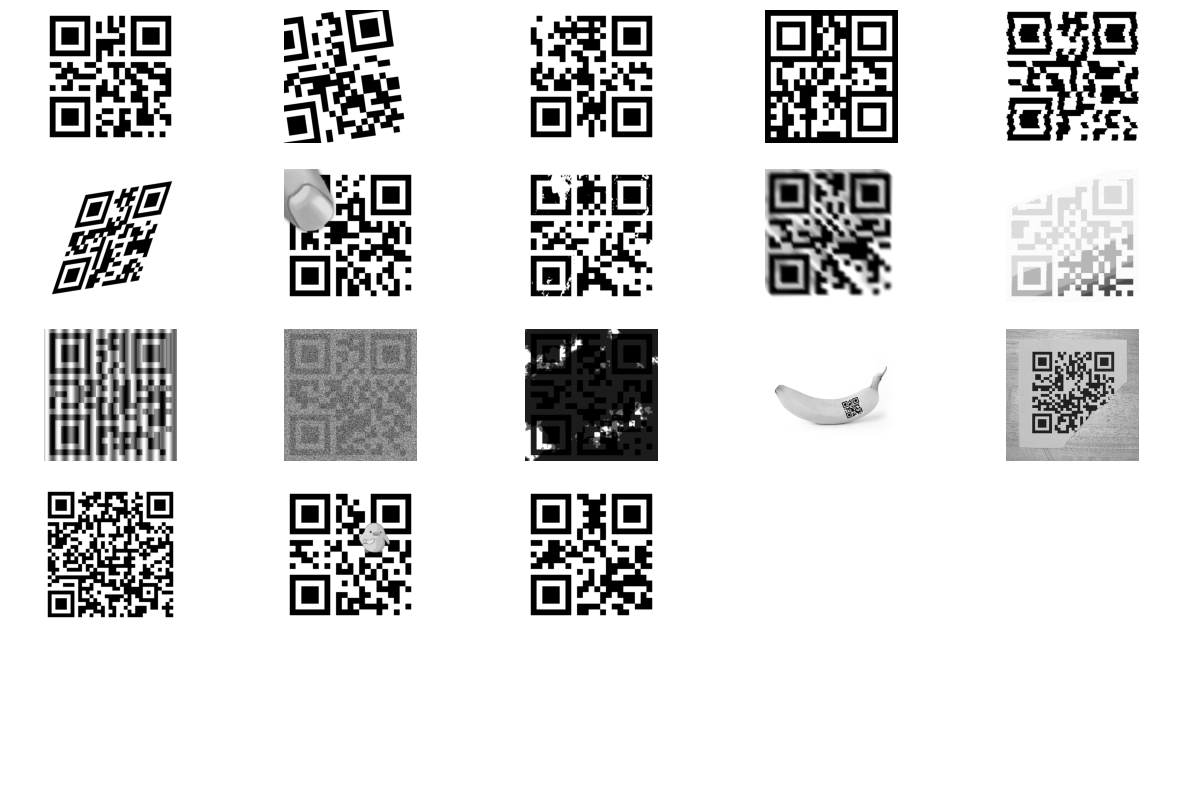

In [1452]:
plt.style.use({'figure.facecolor': 'white'})
plot_all(images)

# Preprocessing #

## Histogram Equalization ##

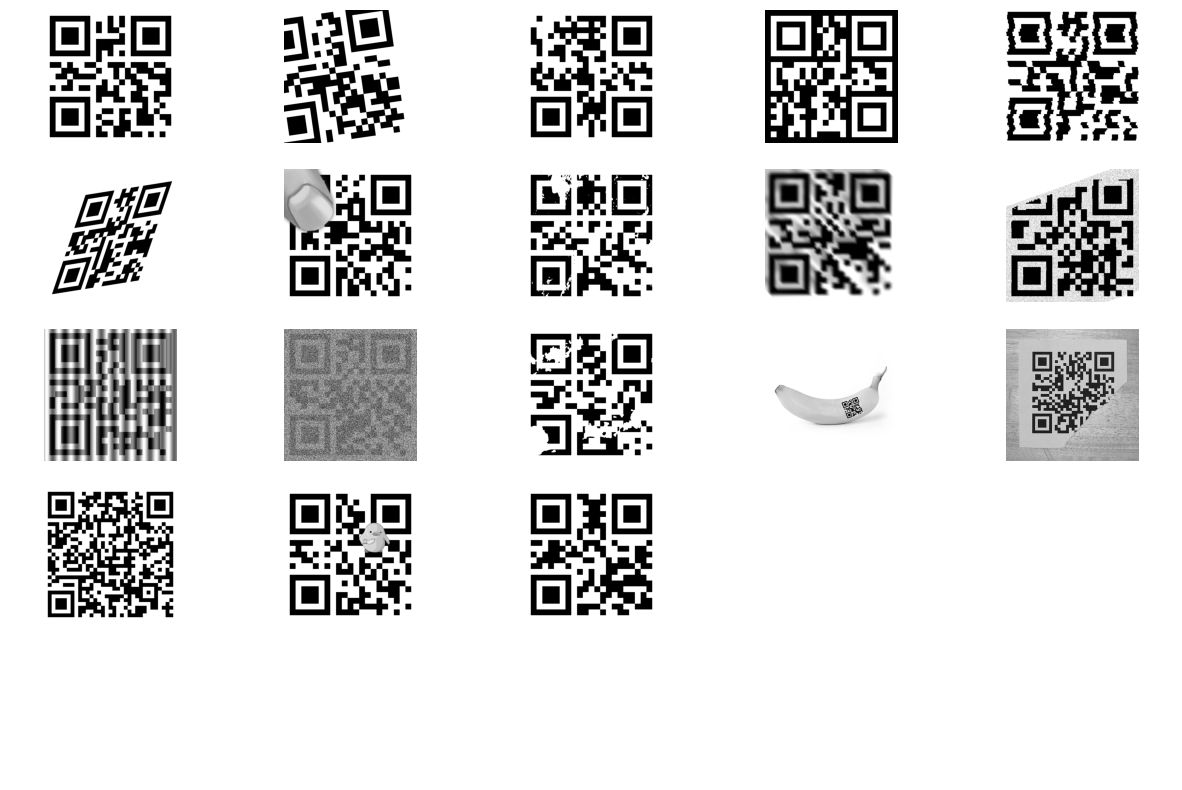

In [1454]:
images_equalized = []
for image in images:
    try:
        image = equalize_histogram(np.uint8(image))
        images_equalized.append(image)
    except Exception as e:
        print(str(e))
        image_white = np.ones_like(image) * 255
        images_equalized.append(image_white)
plot_all(images_equalized)

## Frequency Domain Noise ##

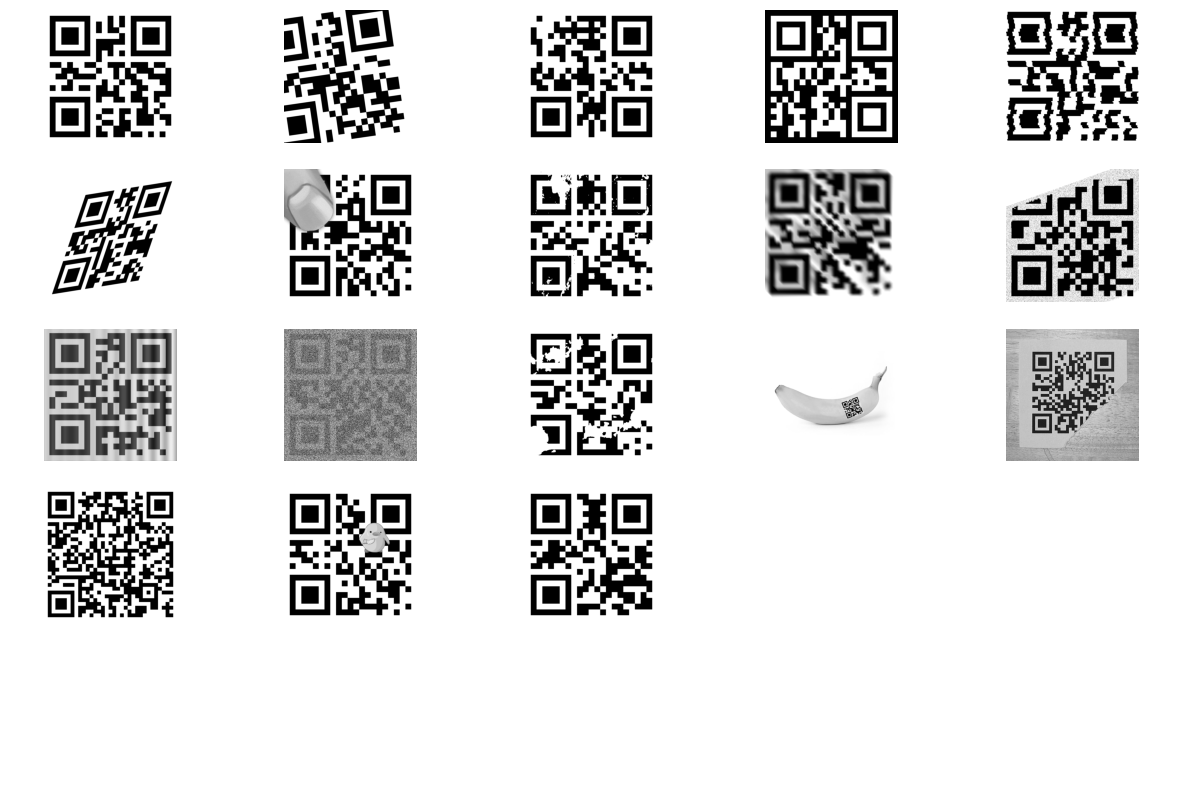

In [1455]:
images_fdn = []
for image in images_equalized:
    try:
        image = remove_anomaly_frequencies(image, 3)
        images_fdn.append(image)
    except Exception as e:
        print(str(e))
        image_white = np.ones_like(image) * 255
        images_fdn.append(image_white)
plot_all(images_fdn)

## Salt and Pepper Noise ##

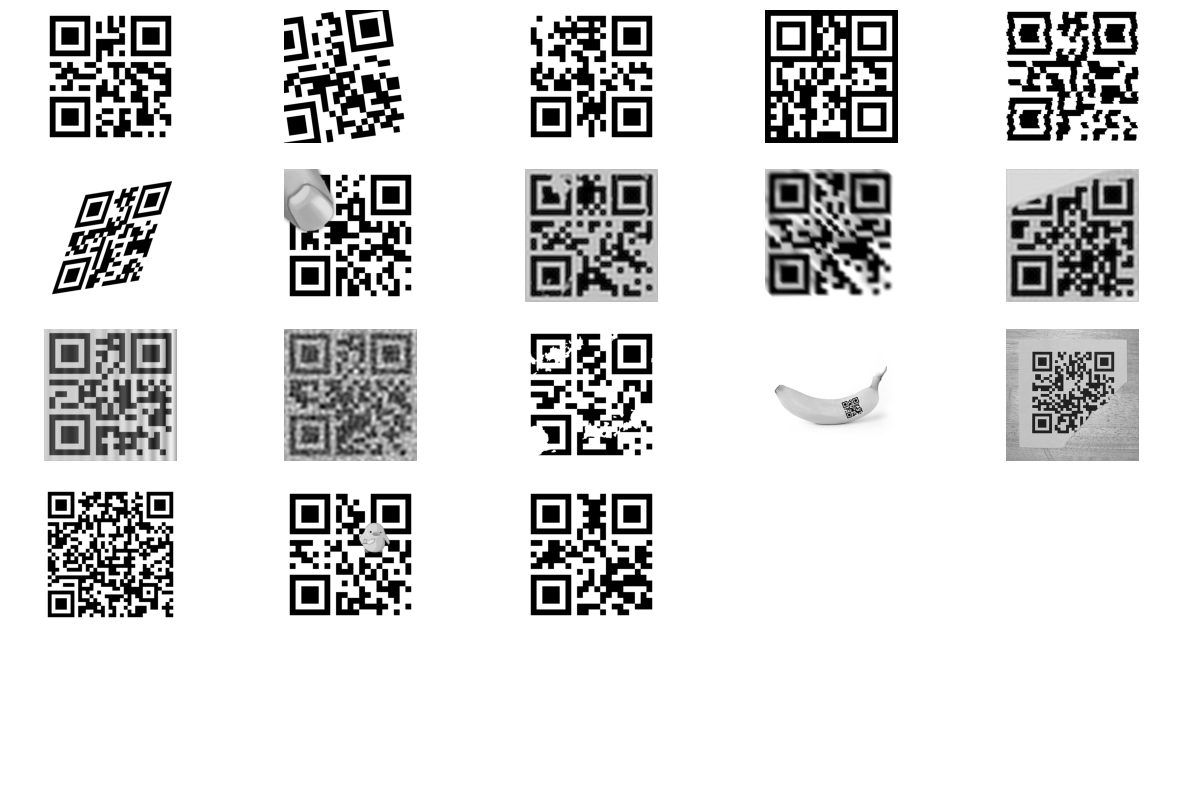

In [1456]:
images_spn = []
for image in images_fdn:
    try:
        image = remove_salt_and_pepper(image, 9)
        images_spn.append(image)
    except Exception as e:
        print(str(e))
        image_white = np.ones_like(image) * 255
        images_spn.append(image_white)
plot_all(images_spn)

# Inversion

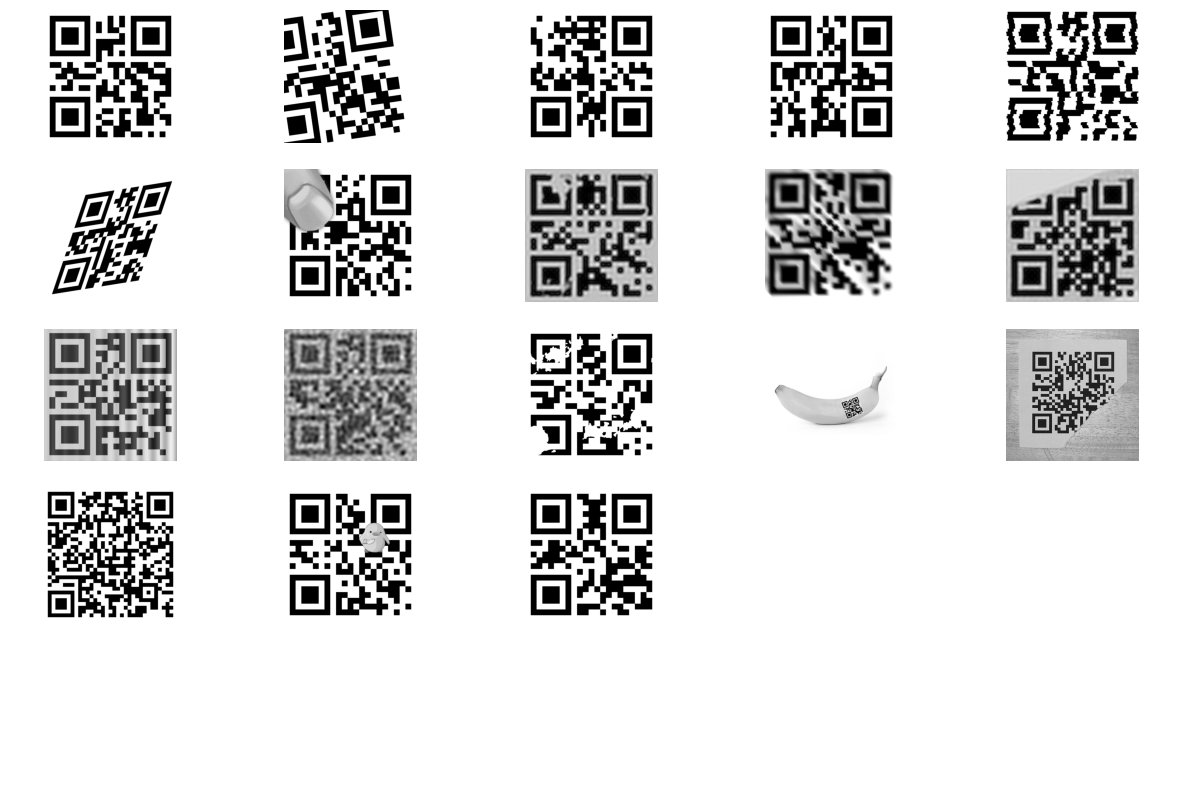

In [1457]:
images_inverted = []
for image in images_spn:
    try:
        image = detect_inversion(np.uint8(image))
        images_inverted.append(image)
    except Exception as e:
        print(str(e))
        image_white = np.ones_like(image) * 255
        images_inverted.append(image_white)
plot_all(images_inverted)

## Thresholding ##

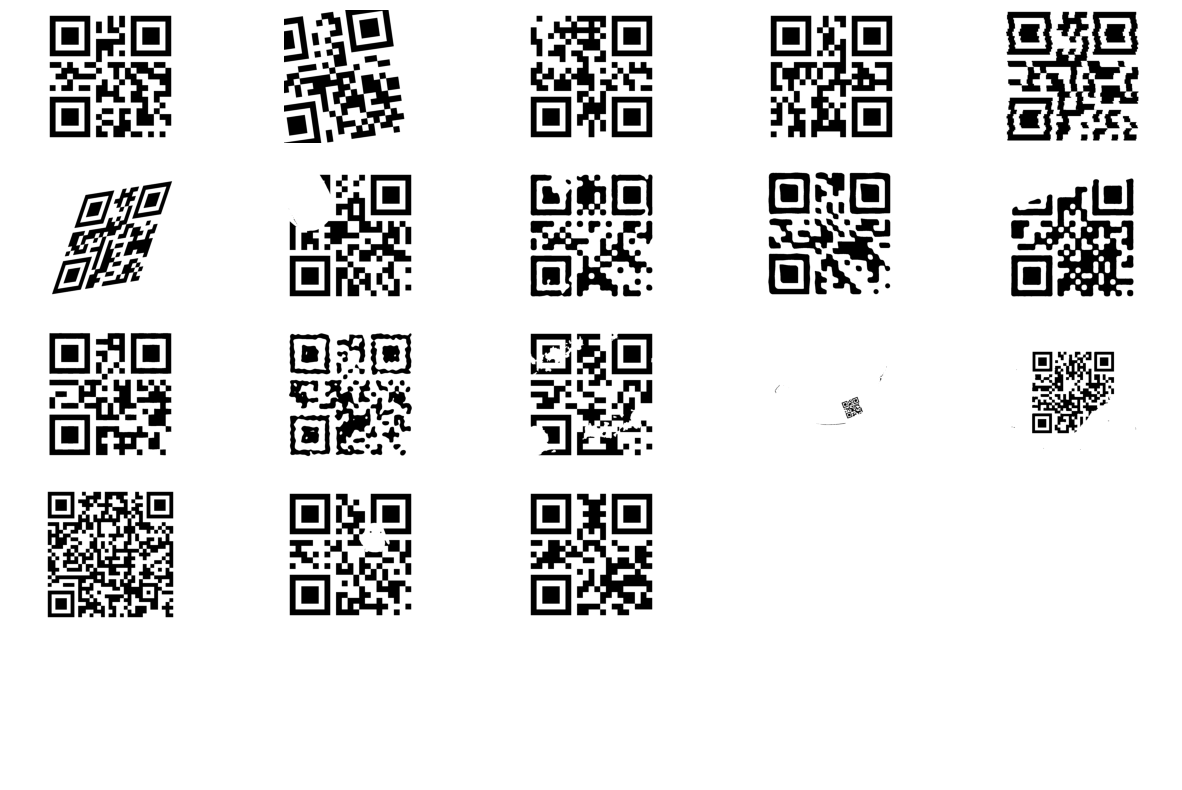

In [1458]:
images_thresholded = []
for image in images_inverted:
    try:
        image = threshold(image, 100)
        images_thresholded.append(image)
    except Exception as e:
        print(str(e))
        image_white = np.ones_like(image) * 255
        images_thresholded.append(image_white)
plot_all(images_thresholded)

## Capturing the QR code most probable area ##

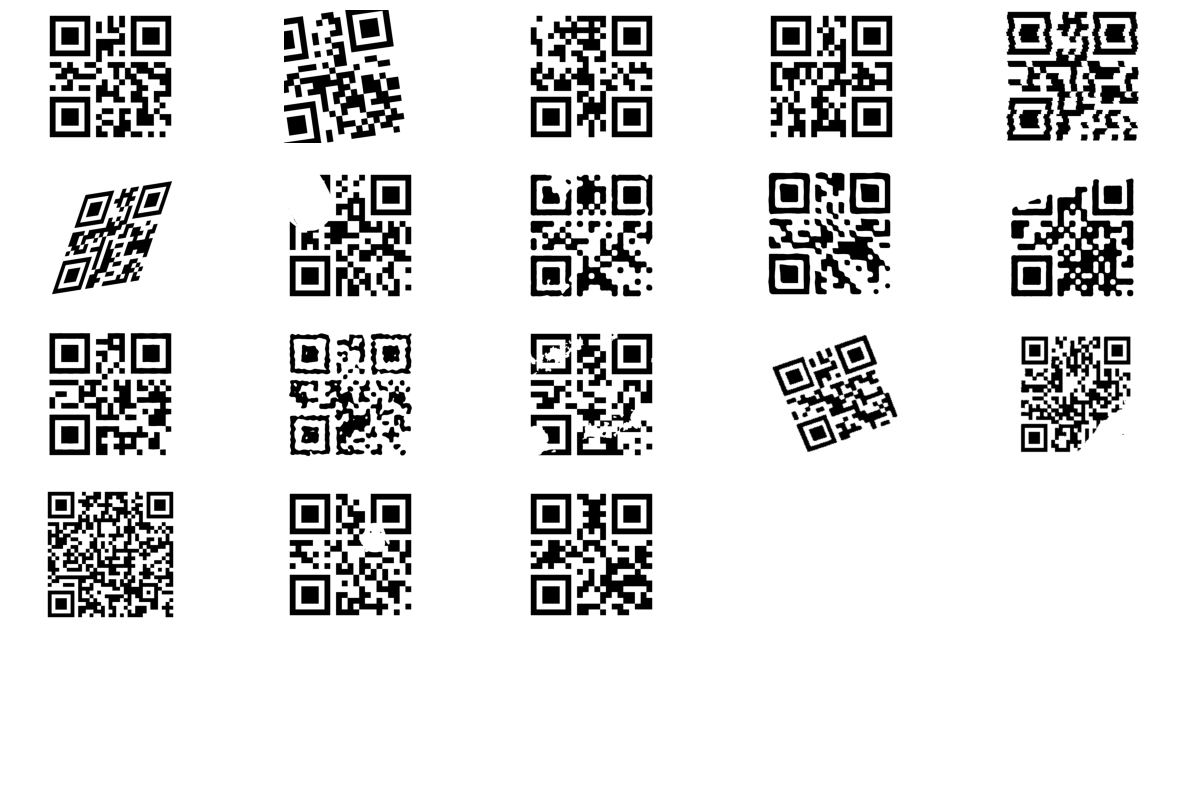

In [1459]:
images_captured = []
for image in images_thresholded:
    try:
        image = capture(image)
        images_captured.append(image)
    except Exception as e:
        print(str(e))
        image_white = np.ones_like(image) * 255
        images_captured.append(image_white)
plot_all(images_captured)

## Tilt Correction ## 

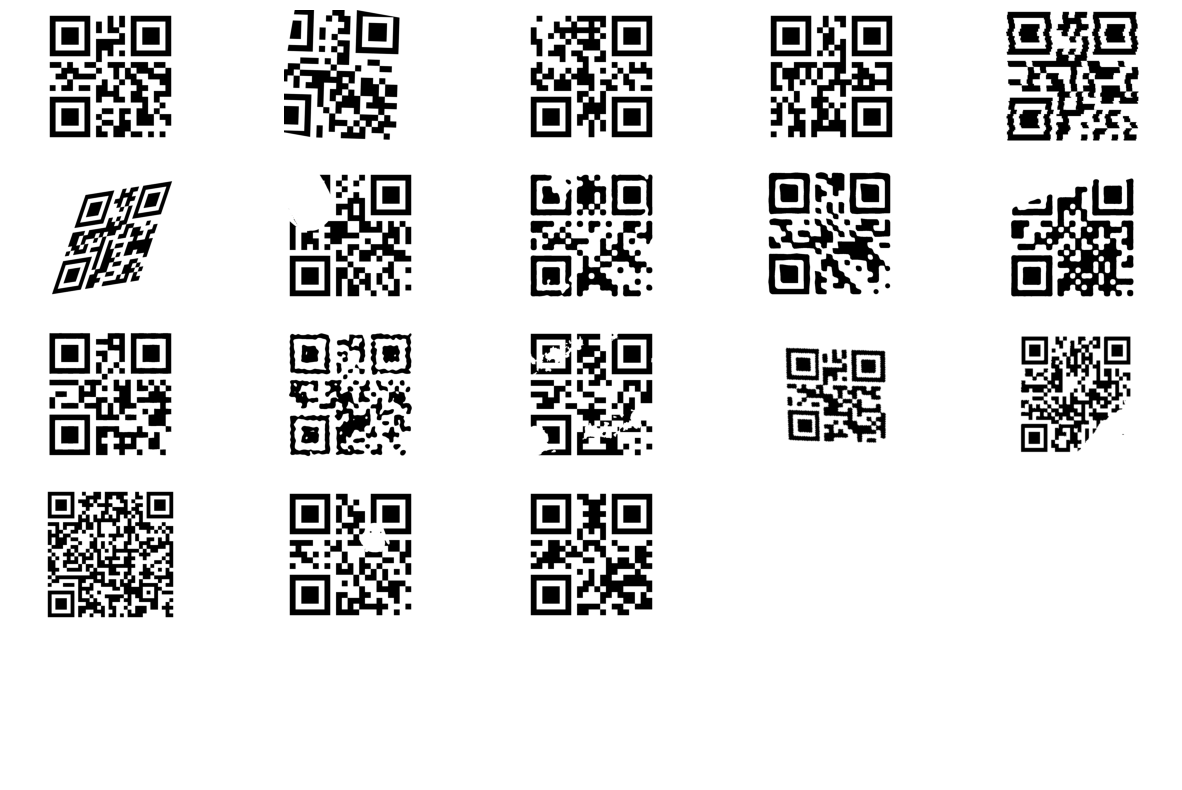

In [1460]:
images_tilt_corrected = []
for image in images_captured:
    try:
        image = check_tilt(image)
        images_tilt_corrected.append(image)
    except Exception as e:
        print(str(e))
        image_white = np.ones_like(image) * 255
        images_tilt_corrected.append(image_white)
plot_all(images_tilt_corrected)

## Detect QR code ##

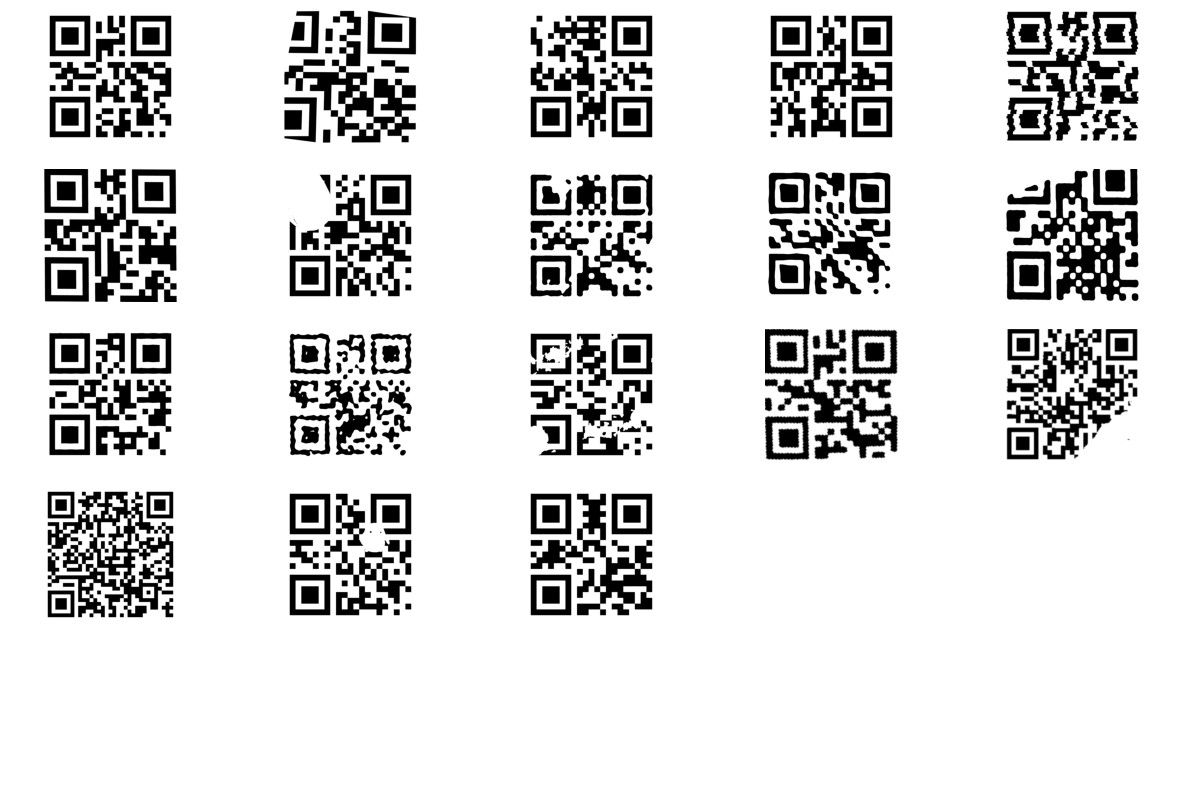

In [1461]:
images_detected = []
i = 0
for image in images_tilt_corrected:
    i = i + 1
    try:
        image = detect_qr_code(image)
        images_detected.append(image)
    except Exception as e:
        print("Image {} detection failed, couldn't find 4 corners:".format(i), str(e))
        images_detected.append(image)
plot_all(images_detected)

# Export Images #

In [1462]:
for i in range(len(images_detected)):
    export_image(images_detected[i], "./preprocessed_images/output_{}.png".format(i+1))